In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import math as mt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import fisher_exact
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [26]:
#importing dataset

path1 = 'Meetup_data_27_11_2024.csv'
new_data = pd.read_csv(path1, header=0)
new_df = pd.DataFrame(new_data)

path2 = 'clustered_events.csv'
train_data = pd.read_csv(path2, header=0)
train_df = pd.DataFrame(train_data)

In [28]:
# Combine descriptions and vectorize using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(train_df['description'])
y_train = train_df['cluster']

# Train a Logistic Regression classifier
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Transform the new descriptions and predict clusters
X_new = vectorizer.transform(new_df['description'])
new_df['predicted_cluster'] = model.predict(X_new)

# Output the results
print("Classified Events:")
print(new_df[['eventname', 'description', 'predicted_cluster']])

# Optionally, save to CSV
output_file = "classified_events.csv"
new_df.to_csv(output_file, index=False)
print(f"Classified events have been exported to {output_file}")

Classified Events:
                                              eventname  \
0     Awaken to Higher Consciousness   --  Tune into...   
1      Drink & Draw Toronto #61: November Vibes 🍂 🍵 🍁 ☕   
2        Cherry Beach: Soccer, 11 a side *READ DETAILS*   
3                                   Cocktails: Get Well   
4     How To Be More Extroverted And Expand Your Soc...   
...                                                 ...   
1214      Welcome to the Community of Spiritual Seekers   
1215                   Orphans’ Holiday dinner 🎄 (~$25)   
1216  In Bruges (2008)  - "Just try not to say anyth...   
1217            Urban Walk: Annual TBTC Boxing Day Hike   
1218  Season Of AI: Build your own agent using Micro...   

                                            description  predicted_cluster  
0     The Toronto Spiritual Experiences Group - Ecka...                  0  
1                                Drink and Draw Toronto                  1  
2                                 Toronto

In [30]:
path3 = '/Users/j/Downloads/classified_events.csv'
data = pd.read_csv(path3, header=0)
df = pd.DataFrame(data)

for cluster in df['predicted_cluster'].unique():
    print(f"The number of events in cluster {cluster} is: ", df[df['predicted_cluster'] == cluster]['predicted_cluster'].count())


# Assign cluster names based on inspection of dominant characteristics
cluster_names = {
    0: "Spiritual and Personal Growth",
    1: "Social and Creative Activities",
    2: "Science and Professional Development"
}
df['cluster_name'] = df['predicted_cluster'].map(cluster_names)

# Preprocessing: Convert date to datetime and aggregate weekly
# Convert date column to datetime and filter necessary columns
data['date'] = pd.to_datetime(data['date'])
data = data[['date', 'attendees', 'predicted_cluster']]

# Calculate daily total attendees for each cluster
daily_totals = data.groupby(['date', 'predicted_cluster'])['attendees'].sum().reset_index()
#print(daily_totals[daily_totals['predicted_cluster']==0])

# Pivot the data for easier handling
pivot_data = daily_totals.pivot(index='date', columns='predicted_cluster', values='attendees').fillna(0)


The number of events in cluster 0 is:  27
The number of events in cluster 1 is:  1010
The number of events in cluster 2 is:  182


In [32]:
# Prepare lagged features for a given time series
def prepare_lagged_features(series, lags=7):
    df = pd.DataFrame({"attendees": series})
    for lag in range(1, lags + 1):
        df[f"lag_{lag}"] = df["attendees"].shift(lag)
    df.dropna(inplace=True)
    return df


In [34]:
#  ensemble forecasting function for 60-day prediction
def ensemble_forecasting_with_metrics(cluster_data, train_end_date, model=None, lags=7, forecast_days=60):
    # Prepare lagged features
    lagged_data = prepare_lagged_features(cluster_data, lags=lags)

    # Split into train and test
    train_data = lagged_data[:train_end_date]
    test_data = lagged_data[train_end_date:]
    X_train, y_train = train_data.drop(columns=["attendees"]), train_data["attendees"]
    X_test, y_test = test_data.drop(columns=["attendees"]), test_data["attendees"]

    # Train the model
    if model is None:
        model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Forecast the next forecast_days (60 days)
    predictions = []
    current_input = X_train.iloc[-1].values  # Start with the most recent lags
    for _ in range(forecast_days):
        next_pred = max(model.predict(current_input.reshape(1, -1))[0], 0)  # Ensure non-negative predictions
        predictions.append(next_pred)
        # Update current_input with the new prediction
        current_input = np.roll(current_input, -1)
        current_input[-1] = next_pred

    forecast_index = pd.date_range(start=cluster_data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq="D")

    # Calculate accuracy metrics
    test_predictions = model.predict(X_test)
    mae = mean_squared_error(y_test, test_predictions, squared=False)
    rmse = mean_squared_error(y_test, test_predictions, squared=True)
    mape = mean_absolute_percentage_error(y_test, test_predictions)

    # Normalize accuracy (100% scale)
    normalized_accuracy = max(0, (1 - mape) * 100)  # Clamp accuracy to be non-negative

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "Accuracy (%)": normalized_accuracy
    }

    return {
        "train": y_train,
        "test": y_test,
        "forecast": pd.Series(predictions, index=forecast_index),
        "test_predictions": pd.Series(test_predictions, index=y_test.index),
        "metrics": metrics
    }



In [36]:
# Process each cluster with metrics and 60-day forecasts
forecast_results = {}
for cluster in pivot_data.columns:
    if cluster == 0:
        train_end_date = '2024-12-01'
    else:
        train_end_date = '2024-12-01'

    # Get cluster-specific data
    cluster_series = pivot_data[cluster]
    cluster_series.index = pd.to_datetime(cluster_series.index)

    # Forecast using ensemble method
    results = ensemble_forecasting_with_metrics(cluster_series, train_end_date=train_end_date, forecast_days=60)
    forecast_results[cluster] = results


Cluster 0 Accuracy Metrics:
MAE: 21.97
Cluster 0 - Average Predicted Attendees for 60 Days: 2.0
Cluster 0 - Predicted Attendees Range for 60 Days: 1.0 to 5.0


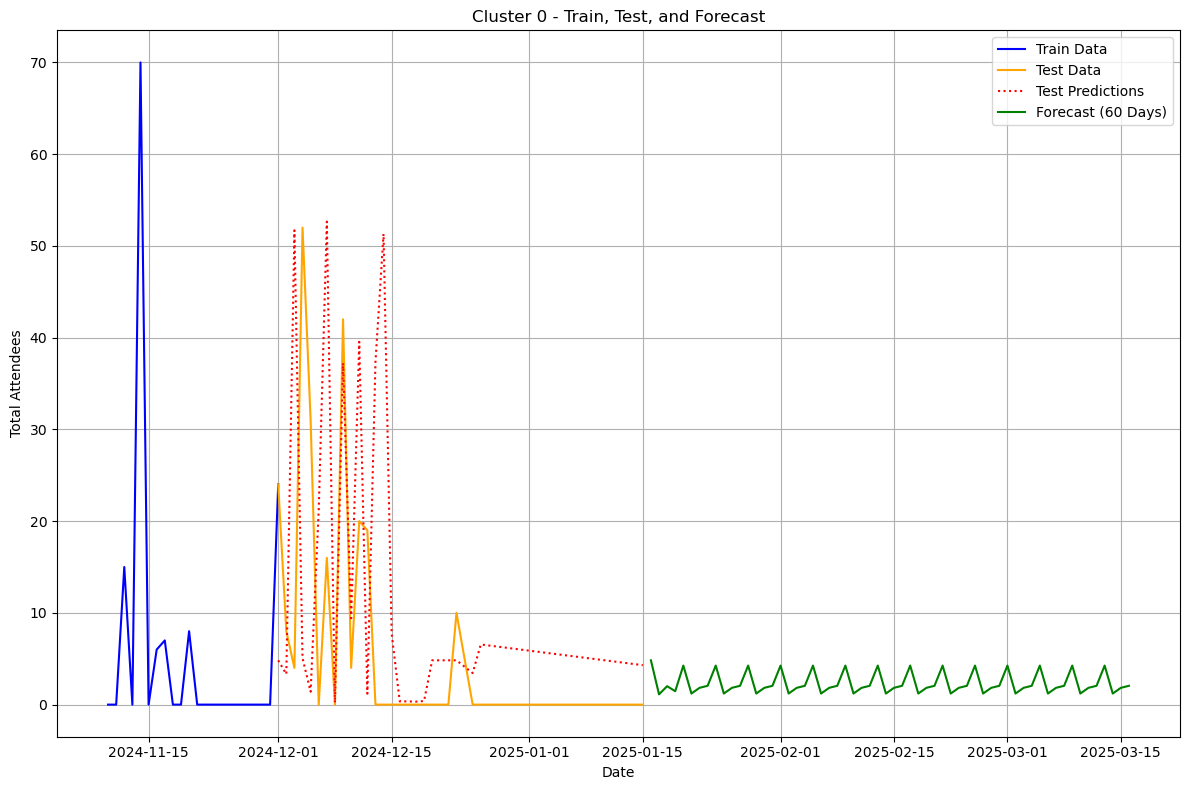

Cluster 1 Accuracy Metrics:
MAE: 357.20
Cluster 1 - Average Predicted Attendees for 60 Days: 540.0
Cluster 1 - Predicted Attendees Range for 60 Days: 441.0 to 794.0


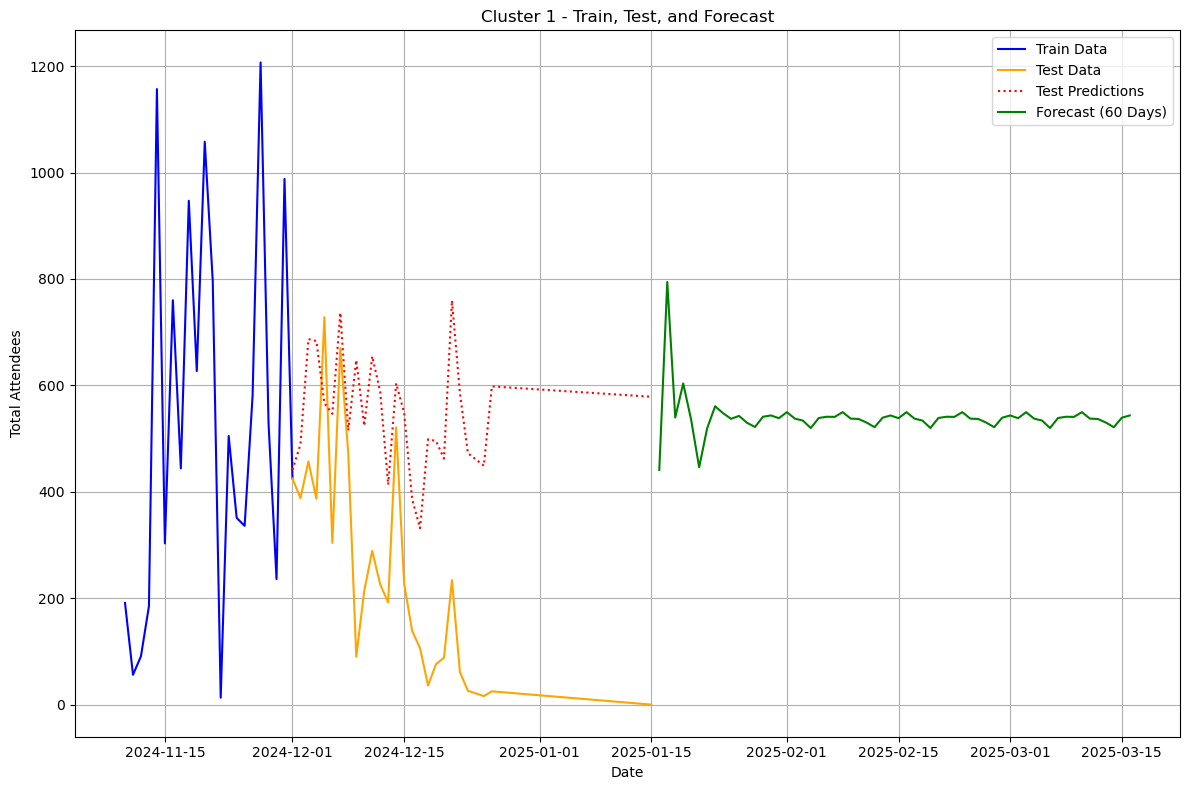

Cluster 2 Accuracy Metrics:
MAE: 114.81
Cluster 2 - Average Predicted Attendees for 60 Days: 65.0
Cluster 2 - Predicted Attendees Range for 60 Days: 45.0 to 142.0


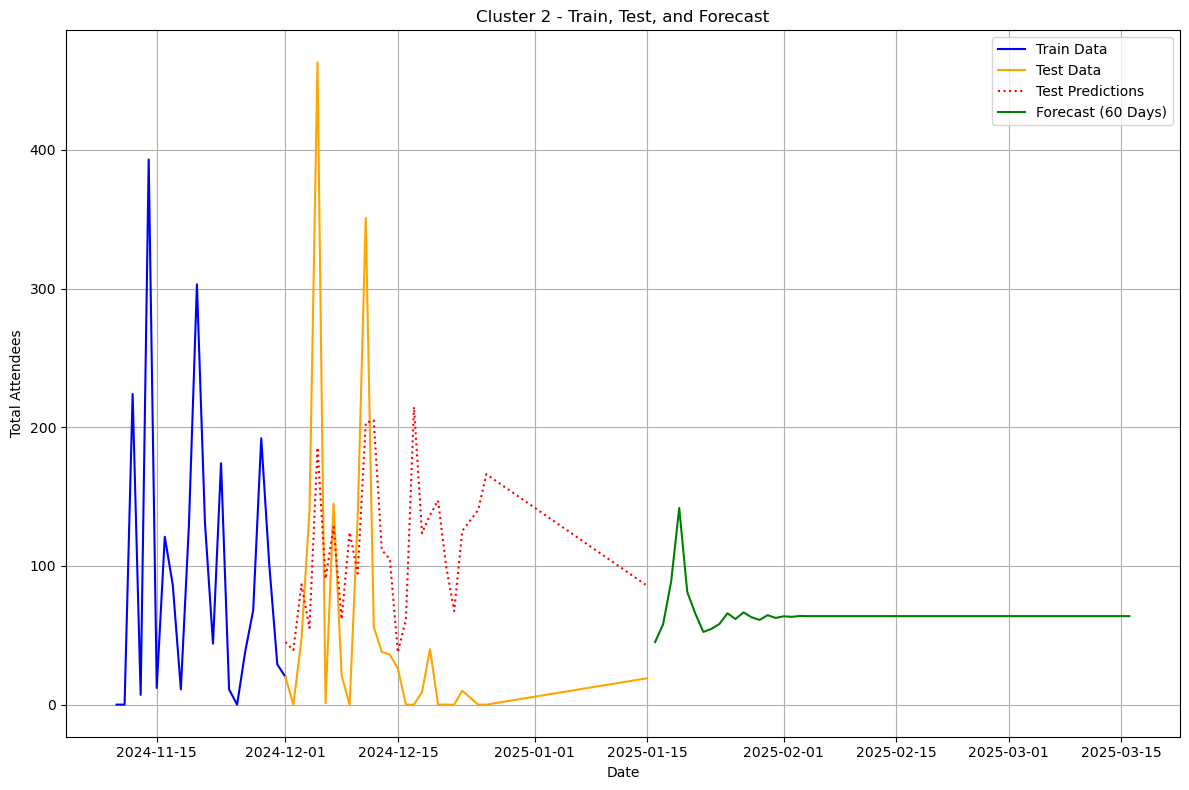

In [40]:
# Plot forecasts with train, test, forecast data, and display accuracy metrics
for cluster, results in forecast_results.items():
    plt.figure(figsize=(12, 8))

    # Plot train data
    plt.plot(results["train"], label='Train Data', color='blue')

    # Plot test data
    plt.plot(results["test"], label='Test Data', color='orange')

    # Plot test predictions
    plt.plot(results["test_predictions"], label='Test Predictions', color='red', linestyle='dotted')

    # Plot forecast
    plt.plot(results["forecast"], label='Forecast (60 Days)', color='green')

    # Customize plot
    plt.title(f'Cluster {cluster} - Train, Test, and Forecast')
    plt.xlabel('Date')
    plt.ylabel('Total Attendees')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Display accuracy metrics
    metrics = results["metrics"]
    print(f"Cluster {cluster} Accuracy Metrics:")
    print(f"MAE: {metrics['MAE']:.2f}")
    #print(f"RMSE: {metrics['RMSE']:.2f}")
    #print(f"MAPE: {metrics['MAPE']:.2%}")
    #print(f"Normalized Accuracy: {metrics['Accuracy (%)']:.2f}%")

    # Calculate and display average and range of predicted attendees
    forecast = results["forecast"]
    average_attendees = forecast.mean()
    min_attendees = forecast.min()
    max_attendees = forecast.max()
    print(f"Cluster {cluster} - Average Predicted Attendees for 60 Days: {round(average_attendees,0)}")
    print(f"Cluster {cluster} - Predicted Attendees Range for 60 Days: {round(min_attendees,0)} to {round(max_attendees,0)}")

    plt.show()